# Многомерная линейная регрессия. Метод главных компонент

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Библиотеки

In [3]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from mlxtend.plotting import plot_decision_regions

from torchvision import datasets
from torchvision import transforms

## Многомерная линейная регрессия

### Простое решение на основе МНК

Тривиально получается, что решение задачи:
$$
    ||\mathbf{X}\mathbf{W} - \mathbf{Y}||_2^2 \to \min_{\mathbf{W}},
$$
является матрица:
$$
    \mathbf{W}^* = \left(\mathbf{X}^{\mathsf{T}}\mathbf{X}\right)^{-1}\mathbf{X}^{\mathsf{T}}\mathbf{Y}
$$

In [5]:
np.random.seed(0)
n = 2
l = 100
K = 2
beta= 0.

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

y = X@W_true + beta*np.random.randn(l, K)

In [61]:
W = np.linalg.inv(X.T@X)@X.T@y

((W-W_true)**2).mean()

1.3288916616271927e-32

In [62]:
np.random.seed(0)
betas = np.linspace(0, 10, 1000)
list_of_errors = []

for beta in betas:
    y = X@W_true + beta*np.random.randn(l, K)
    
    W = np.linalg.inv(X.T@X)@X.T@y

    list_of_errors.append(((W-W_true)**2).mean())

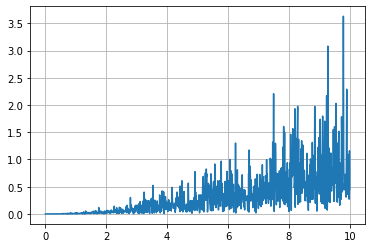

In [63]:
plt.plot(betas, list_of_errors)

plt.grid()
plt.show()

### Воспользуемся SVD

SVD разложение:
$$
    \mathbf{X} = \mathbf{V}\mathbf{D}\mathbf{U}^{\mathsf{T}}.
$$

Лемма:
$$
    \mathbf{X}^{+} = \left(\mathbf{X}^{\mathsf{T}}\mathbf{X}\right)^{\mathsf{T}}\mathbf{X}^{\mathsf{T}} = \mathbf{U}\mathbf{D}^{-1}\mathbf{V}^{\mathsf{T}}
$$


Получаем:
$$
    \mathbf{W}^* = \mathbf{U}\mathbf{D}^{-1}\mathbf{V}^{\mathsf{T}}\mathbf{Y}
$$

In [64]:
np.random.seed(0)
n = 2
l = 100
K = 2
beta= 0.

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

y = X@W_true + beta*np.random.randn(l, K)

In [65]:
V, d, U = np.linalg.svd(X, full_matrices=False)

D = np.eye(len(d))*d
lambd = d**2

In [66]:
np.max(lambd)/np.min(lambd)

1.049588919547096

In [67]:
W = (U.T@np.linalg.inv(D)@V.T)@y

((W-W_true)**2).mean()

1.8681520460556188e-32

In [85]:
np.random.seed(0)
mus = np.linspace(0, 1, 10)
list_of_errors = []

for mu in mus:
    lambd_new = np.array(lambd)
    lambd_new[1] = mu*lambd_new[0]
    d_new = np.sqrt(lambd_new)
    D_new = np.eye(len(d_new))*d_new
    X_new = V@D_new@U
    
    y = X_new@W_true
    
    W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

    list_of_errors.append(((W-W_true)**2).mean())

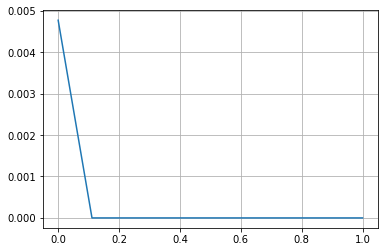

In [86]:
plt.plot(mus, list_of_errors)

plt.grid()
plt.show()

In [73]:
np.random.seed(0)
mus = np.linspace(0.01, 1., 100)
betas = np.linspace(0.01, 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu*lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U

        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((W-W_true)**2).mean()

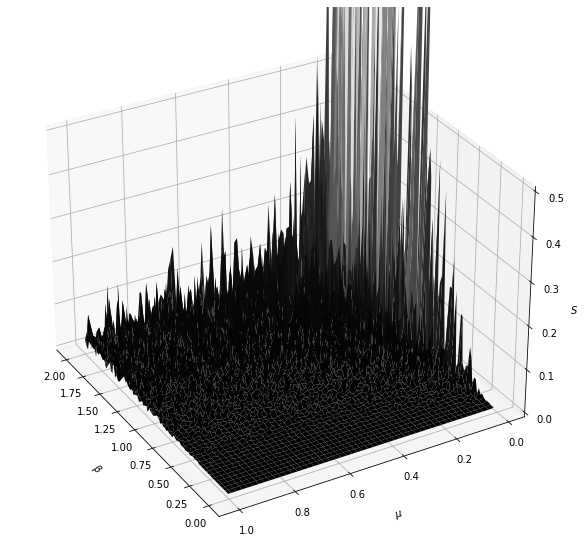

In [74]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]

fig = plt.figure(figsize=(14.0, 10.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad= 14), ax.set_ylabel(r'$\mu$', labelpad= 14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 0.5)), ax.view_init(30, 150)

plt.show()

In [75]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu*lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U

        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((y-X_new@W)**2).mean()

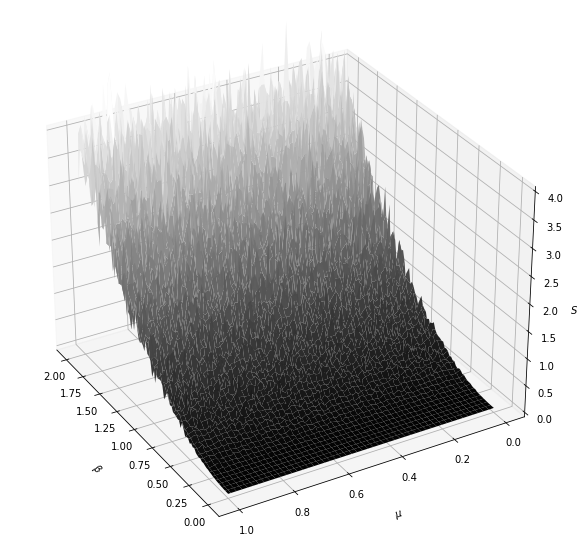

In [76]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]

fig = plt.figure(figsize=(14.0, 10.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad= 14), ax.set_ylabel(r'$\mu$', labelpad= 14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 4)), ax.view_init(30, 150)

plt.show()

## Регуляризация в многомерной регрессии

### Простое решение на основе МНК

Тривиально получается, что решение задачи:
$$
    ||\mathbf{X}\mathbf{W} - \mathbf{Y}||_2^2 + \tau ||\mathbf{W}||_2^2 \to \min_{\mathbf{W}},
$$
является матрица:
$$
    \mathbf{W}^* = \left(\mathbf{X}^{\mathsf{T}}\mathbf{X} + \tau\mathbf{I}\right)^{-1}\mathbf{X}^{\mathsf{T}}\mathbf{Y}
$$

### Решение через SVD

Лемма:
$$
\mathbf{W}^* = \mathbf{U}\mathbf{D}\left(\mathbf{D}^2+\tau\mathbf{I}\right)^{-1}\mathbf{V}^{\mathsf{T}}
$$

In [87]:
np.random.seed(0)
n = 2
l = 100
K = 2

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

In [88]:
tau = 10.
W = (U.T@D@np.linalg.inv(D**2 + tau*np.eye(len(D)))@V.T)@y

((W-W_true)**2).mean()

0.0031511498017577394

In [89]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
tau = 10.
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu*lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U

        y = X_new@W_true + beta*np.random.randn(l, K)
        W = (U.T@D_new@np.linalg.inv(D_new**2 + tau*np.eye(len(D_new)))@V.T)@y

        list_of_errors[str(beta)][str(mu)] = ((W-W_true)**2).mean()

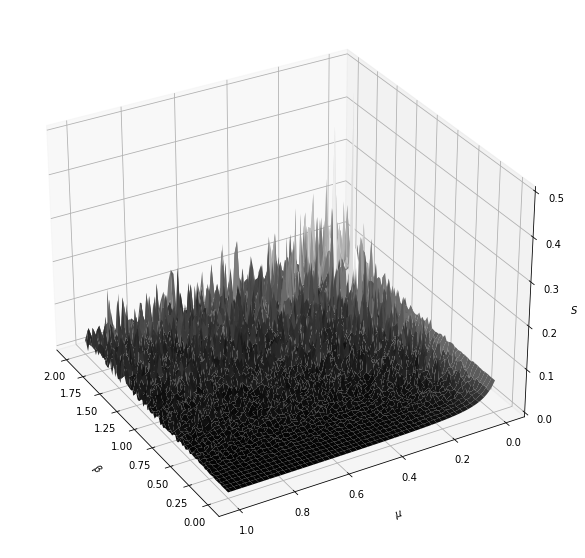

In [90]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]

fig = plt.figure(figsize=(14.0, 10.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad= 14), ax.set_ylabel(r'$\mu$', labelpad= 14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 0.5)), ax.view_init(30, 150)

plt.show()

In [91]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu*lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U

        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((y-X_new@W)**2).mean()

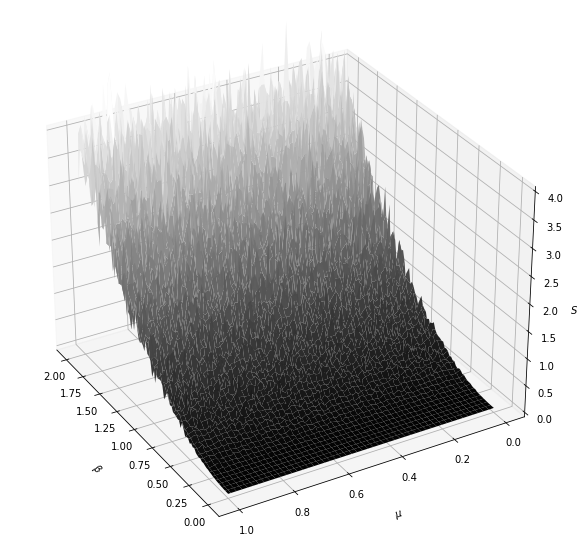

In [92]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]

fig = plt.figure(figsize=(14.0, 10.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad= 14), ax.set_ylabel(r'$\mu$', labelpad= 14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 4)), ax.view_init(30, 150)

plt.show()

## Метод главных компонент

In [23]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True)
X_train = MNIST_train.data.view([-1, 784]).cpu().numpy()
Y_train = MNIST_train.targets.cpu().numpy()

MNIST_test = datasets.MNIST('./mnist', train=False, download=True)
X_test = MNIST_test.data.view([-1, 784]).cpu().numpy()
Y_test = MNIST_test.targets.cpu().numpy()

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Processing...
Done!


In [24]:
pca = PCA(2)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.fit_transform(X_test)

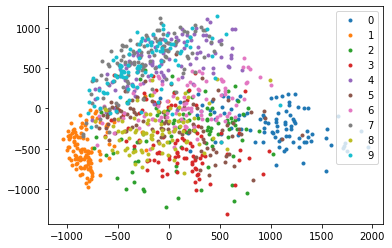

In [25]:
for k in np.unique(Y_train):
    idx = np.where(Y_train[:1000] == k)[0]
    plt.plot(X_train_low[idx, 0], X_train_low[idx, 1], '.', label = str(k))
    
plt.legend(loc='best')
plt.show()

In [26]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0, device='cpu'):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        self.to(device)
        
    def forward(self, input):
        return self.layers(input)
    
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                              shuffle=True)
        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            
            
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred = []
    real = []
    for x, y in tqdm(generator, leave=False):
        x = x.to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [28]:
model = Perceptron(device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train), 
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test), 
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model, 
        dataset=dataset_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       980
           1       0.98      0.96      0.97      1135
           2       0.80      0.90      0.85      1032
           3       0.92      0.82      0.87      1010
           4       0.92      0.89      0.91       982
           5       0.64      0.91      0.75       892
           6       0.95      0.91      0.93       958
           7       0.94      0.90      0.92      1028
           8       0.83      0.72      0.77       974
           9       0.92      0.84      0.88      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [29]:
pca = PCA(2)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [30]:
model = Perceptron(input_dim=2, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low), 
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low), 
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model, 
        dataset=dataset_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.51      0.86      0.64       980
           1       0.69      0.75      0.72      1135
           2       0.18      0.01      0.02      1032
           3       0.30      0.80      0.44      1010
           4       0.27      0.11      0.16       982
           5       0.00      0.00      0.00       892
           6       0.24      0.02      0.04       958
           7       0.18      0.58      0.28      1028
           8       0.00      0.00      0.00       974
           9       0.29      0.18      0.23      1009

    accuracy                           0.34     10000
   macro avg       0.27      0.33      0.25     10000
weighted avg       0.28      0.34      0.26     10000



In [31]:
pca = PCA(10)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [32]:
model = Perceptron(input_dim=10, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low), 
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low), 
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model, 
        dataset=dataset_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       980
           1       0.89      0.94      0.91      1135
           2       0.82      0.77      0.79      1032
           3       0.76      0.81      0.79      1010
           4       0.70      0.79      0.75       982
           5       0.66      0.64      0.65       892
           6       0.84      0.79      0.82       958
           7       0.82      0.85      0.83      1028
           8       0.79      0.65      0.71       974
           9       0.69      0.66      0.67      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [33]:
pca = PCA(100)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [34]:
model = Perceptron(input_dim=100, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low), 
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low), 
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model, 
        dataset=dataset_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       980
           1       0.94      0.97      0.95      1135
           2       0.92      0.87      0.89      1032
           3       0.89      0.85      0.87      1010
           4       0.88      0.91      0.90       982
           5       0.86      0.83      0.84       892
           6       0.91      0.91      0.91       958
           7       0.87      0.89      0.88      1028
           8       0.86      0.84      0.85       974
           9       0.86      0.86      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## Метод главных компонент для изображения

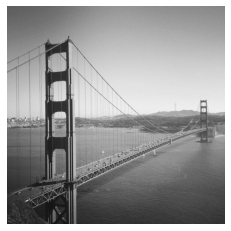

In [35]:
img = imread('picture.jpg').mean(axis=-1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.show()

In [36]:
V, d, U = np.linalg.svd(img, full_matrices=False)
D = np.diag(d)


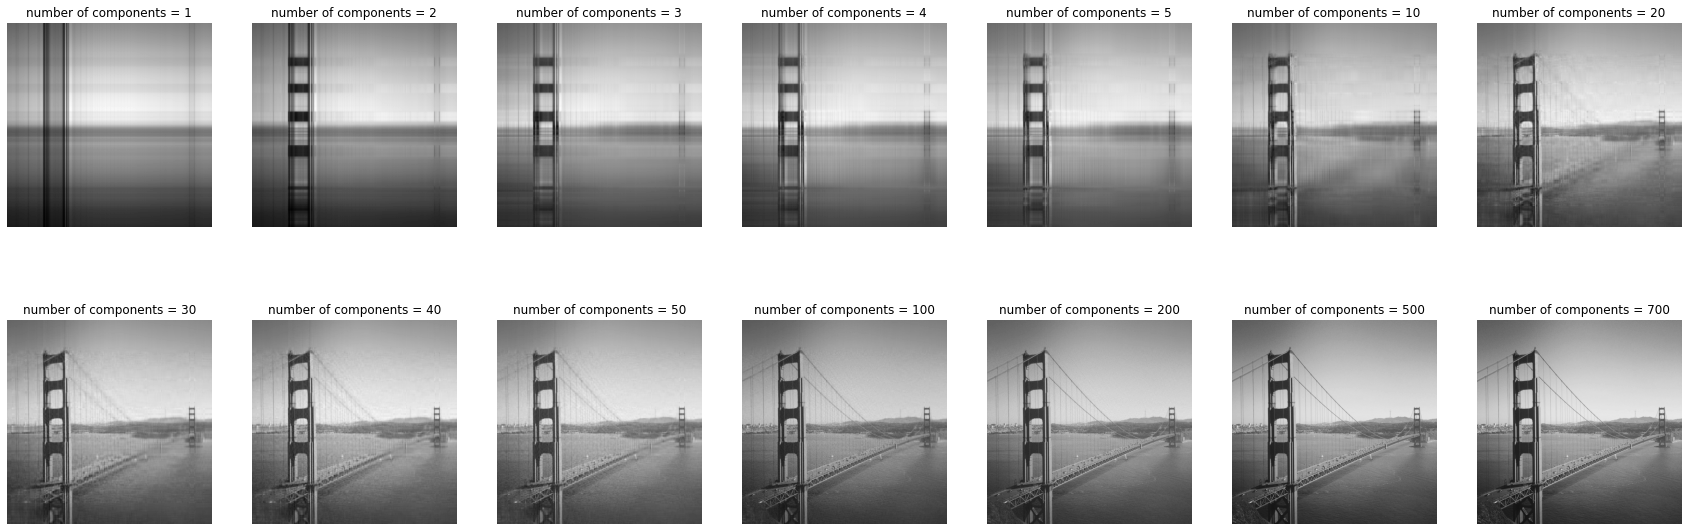

In [37]:
ranks = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 500, 700]

fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(2, 7)
ax = np.empty([len(ranks)], dtype=object)
for i in range(len(ranks)):
    ax[i] = fig.add_subplot(gs[i])

for i, k in enumerate(ranks):
    img_new = V[:, :k] @ D[:k,:k] @ U[:k,:]
    ax[i].imshow(img_new, cmap='gray'), ax[i].axis('off')
    ax[i].set_title('number of components = {}'.format(k))

plt.show()

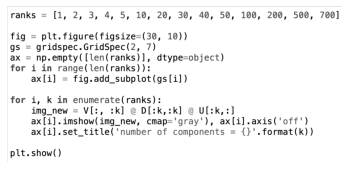

In [38]:
img = imread('lecture.png').mean(axis=-1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.show()

In [39]:
V, d, U = np.linalg.svd(img, full_matrices=False)
D = np.diag(d)


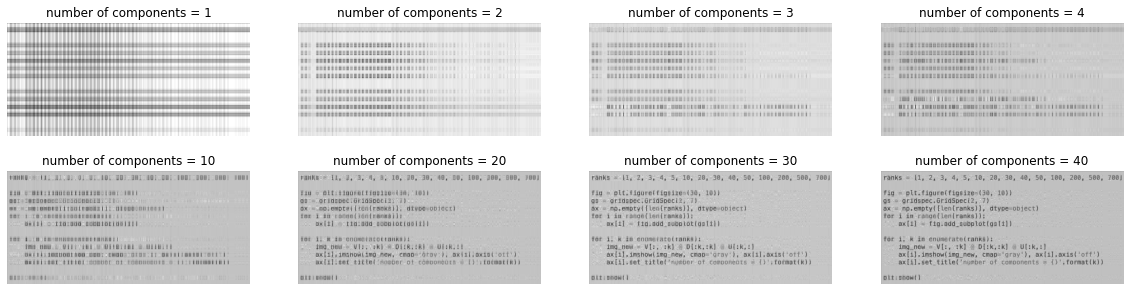

In [40]:
ranks = [1, 2, 3, 4, 10, 20, 30, 40]

fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(2, 4)
ax = np.empty([len(ranks)], dtype=object)
for i in range(len(ranks)):
    ax[i] = fig.add_subplot(gs[i])

for i, k in enumerate(ranks):
    img_new = V[:, :k] @ D[:k,:k] @ U[:k,:]
    ax[i].imshow(img_new, cmap='gray'), ax[i].axis('off')
    ax[i].set_title('number of components = {}'.format(k))

plt.show()

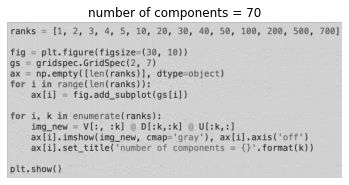

In [41]:
epsilon = 1e-3
for k in range(1, len(d)):
    if (d[k+1:]**2).sum()/(d**2).sum() < epsilon:
        break

img_new = V[:, :k] @ D[:k,:k] @ U[:k,:]
plt.imshow(img_new, cmap='gray'), plt.axis('off')
plt.title('number of components = {}'.format(k))
plt.show()

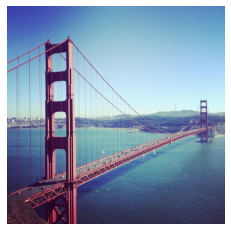

In [42]:
img = imread('picture.jpg')
plt.imshow(img)
plt.axis('off')

plt.show()

In [43]:
V_1, d, U_1 = np.linalg.svd(img[:,:,0], full_matrices=False)
D_1 = np.diag(d)

V_2, d, U_2 = np.linalg.svd(img[:,:,1], full_matrices=False)
D_2 = np.diag(d)

V_3, d, U_3 = np.linalg.svd(img[:,:,2], full_matrices=False)
D_3 = np.diag(d)


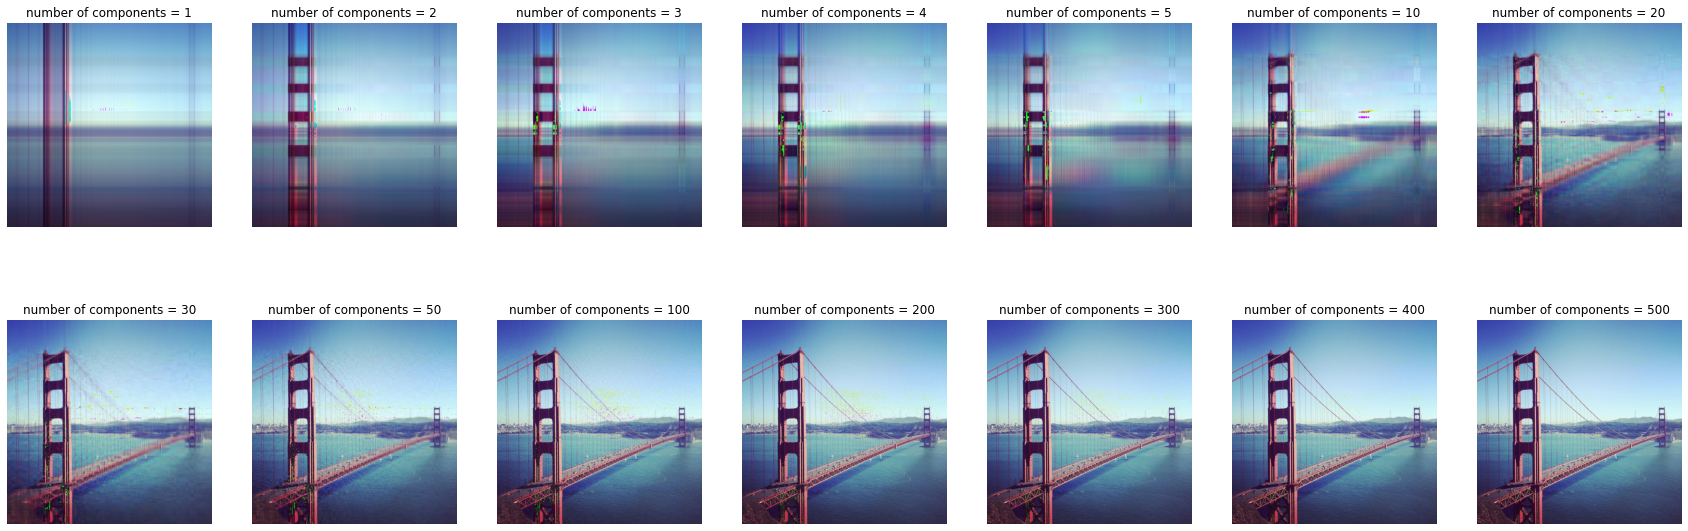

In [44]:
ranks = [1, 2, 3, 4, 5, 10, 20, 30, 50, 100, 200, 300, 400, 500]

fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(2, 7)
ax = np.empty([len(ranks)], dtype=object)
for i in range(len(ranks)):
    ax[i] = fig.add_subplot(gs[i])
    
img_new = np.empty_like(img)
for i, k in enumerate(ranks):
    img_new[:, :, 0] = V_1[:, :k] @ D_1[:k,:k] @ U_1[:k,:]
    img_new[:, :, 1] = V_2[:, :k] @ D_2[:k,:k] @ U_2[:k,:]
    img_new[:, :, 2] = V_3[:, :k] @ D_3[:k,:k] @ U_3[:k,:]
    ax[i].imshow(img_new), ax[i].axis('off')
    ax[i].set_title('number of components = {}'.format(k))

plt.show()